<a href="https://colab.research.google.com/github/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_1/Feature_Engineering_Celeb_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
from IPython.display import clear_output

In [3]:
!pip install scikit-learn
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
clear_output()

## Settings

In [10]:
base_dir = "/content/drive/MyDrive/DIO Baires Dev"
csv_attributes_path = os.path.join(base_dir, 'datasets/celeb_a/list_attr_celeba.csv')

__O Problema do Desbalanceamento Multilabel__

Em um cenário multilabel, cada amostra pode ter um ou mais rótulos (classes), o que significa que o modelo precisa lidar com a combinação de múltiplos rótulos ao mesmo tempo. Isso cria uma situação em que o desbalanceamento pode ocorrer em nível de classe individual (ou seja, algumas classes podem ser raras em todo o dataset), em nível de rótulo (onde uma amostra pode ter uma combinação específica de rótulos menos frequentes) ou em nível de instância (onde algumas amostras têm muitos rótulos enquanto outras têm apenas alguns).

Quando há um desbalanceamento significativo, o modelo pode tender a prever as classes mais frequentes corretamente, enquanto ignora as classes menos representadas, prejudicando a capacidade de generalização e levando a uma performance desigual.

__Veja abaixo o total de ocorrências de cada classe no dataset Celeb A completo__

## Loading the data

In [34]:
df = pd.read_csv(csv_attributes_path).replace(-1, 0)

Classe menos representada: Bald = 4547
Classe mais representada: No_Beard = 169158


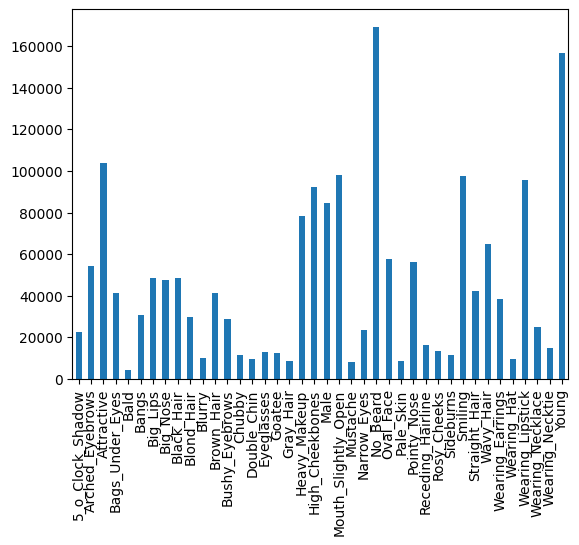

In [12]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

## Exploratory Data Analysis

A matriz de correlação é um excelente ponto de partida para esta análise. Já é possível encontrar nela pista de variáveis correlacionadas, negativa ou positivamente que devem influenciar no funcionamento do modelo.

`No_beard`, que é um atributo que também pode ser masculino, está inversamente relacionado a alguns tipos de barba, a Male e positivamente relacionado à atributos femininos.

Já é possível encontrar indícios de classes que precisarão de data augmentation estratégico: __por exemplo, algumas características podem não estar presentes nos rostos femininos, mas é possível que mulheres as tenham.__

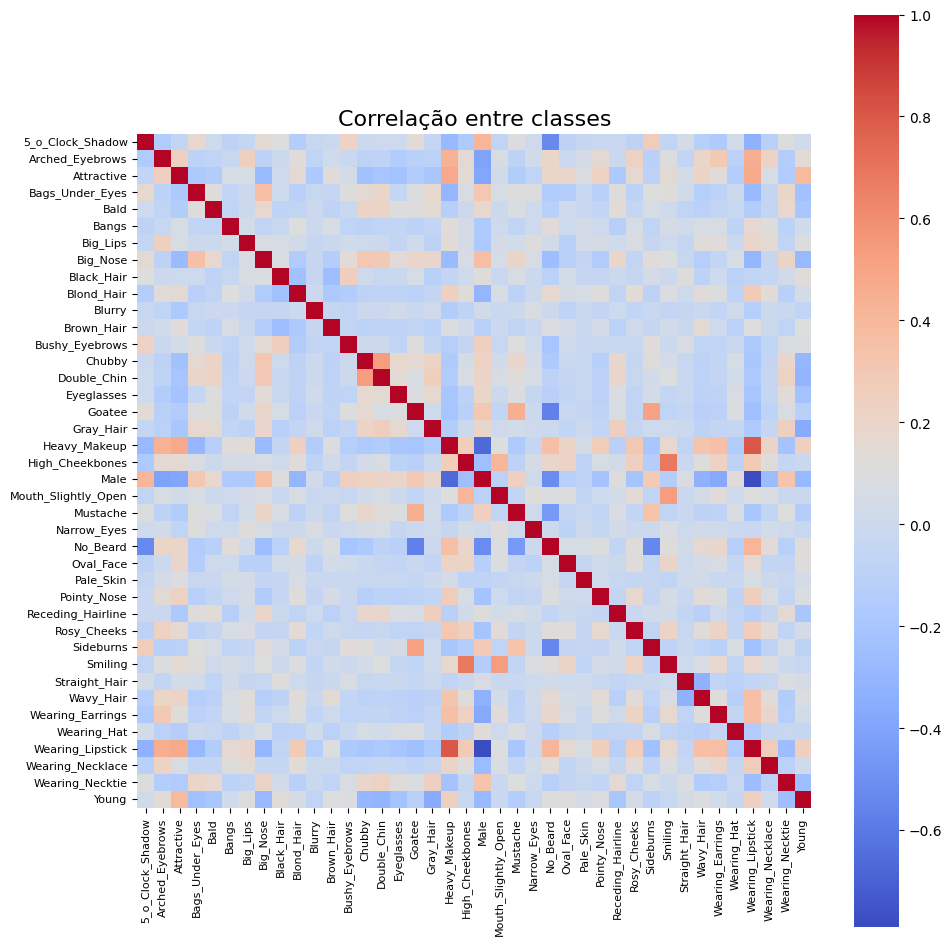

In [13]:
corr_matrix = df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    xticklabels=True,
    yticklabels=True,
    cbar=True,
    square=True
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.title("Correlação entre classes", fontsize=16)
plt.tight_layout()
plt.show()

Um clustering hierárquico pode ajudar a visualizar melhor essas relações. O número de clusters foi arbitrário.

---

Observe a classe Male e a quais rótulos ela está mais associada. Nesse dataset, geralmente homens possuem uma barba 5_o_clock_shadow, bolsões abaixo dos olhos (acúmulo de gordura), entradas, nariz grande, dentre outros. Com destaque para o cabelo cinza.

---

O cabelo cinza está fortemente associado a classe Male provavelmente por homens nem sempre pintarem os fios grisalhos. Ao analisar o dendograma a seguir, é possível perceber que ter fios cinzas é oposto a ser jovem. Logo, mulheres não jovens, que não possuem cabelo grisalho podem ser classificadas como jovens.

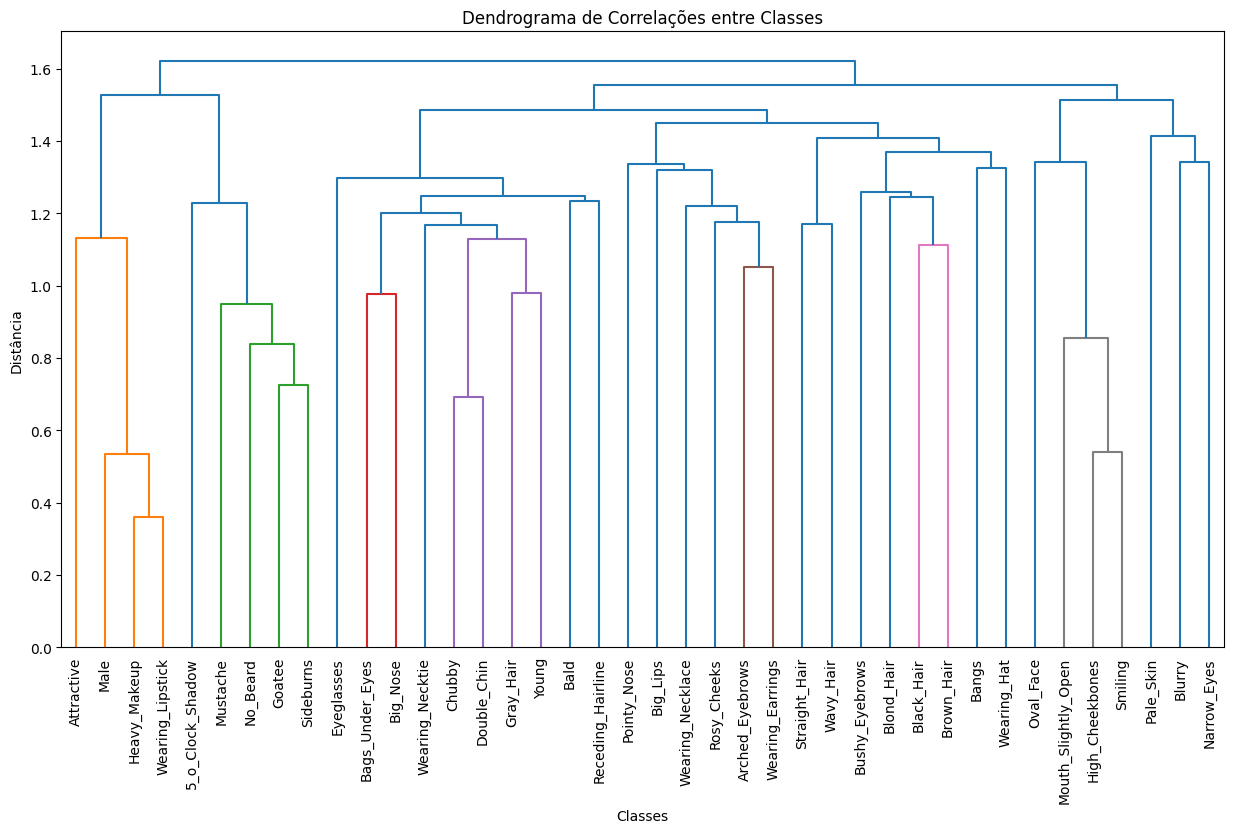

In [14]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
clustering = AgglomerativeClustering(
    n_clusters=10,
    metric='precomputed',
    linkage='average'
)
distance_matrix = pdist(1 - abs(corr_matrix.values), metric='euclidean')
Z = linkage(distance_matrix, method='average')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma de Correlações entre Classes")
plt.xlabel("Classes")
plt.ylabel("Distância")
plt.show()


__Vamos analisar o dendogrma__

- O grupo laranja evidencia que a `atratividade`, que é um atributo subjetivo, está mais próxima de atributos que estão fortemente correlacionados à mulheres, ou não Male. A atratividade é um conceito subjetivo, varia entre culturas, e talvez seja adequado retirá-lo.
    
- `Attractive` está positivamente associado a uso de maquiagem e negativamente a Male.

- Já no grupo verde, que indica estilos de barba, como costeletas, bigode, cavanhaque, os atributos são correlacionados a Male, exceto No_Beard.
  - podemos excluir `no_beard`.

- Em relação às cores de cabelo, um cabelo só pode ser loiro, preto, cinza ou castanho. Parece estar ok essa hierarquia. Já o cabelo cinza está associado a ser não jovem: se não tem cabelo cinza é jovem. Mas, nessa base cabelo cinza é mais frequente em homens. O modelo pode entender que uma pessoa não é jovem se tiver cabelo cinza, e como este é mais frequente em homens o modelo pode falhar em identificar mulheres mais idosas.

__Conclusão__

- Após esses ajustes, é importante observar quais características estão nas folhas do dendograma, o que pode indicar a necessidade de um ajuste fino nas imagens para que a rede diferencie melhor uma característica da outra. Ex.: Bangs e uso de chapéu parecem estar bem relacionados. Em um determinado ponto, a imagem será classificada em um dos atributos. Pode acontecer de a rede confundir franja com chapéu e vice-versa.

- __Entretanto, esses ajustes serão mais estratégicos após o treino da rede e inspeção das métricas de classificação.__

## Some feature engineering

__Aplicando as modificações__

In [35]:
df = df.drop(
    columns=['No_Beard', 'Attractive']
)

__Clusterizando novamente__

dendograma após a remoção dos atributos No_Beard e Attractive.

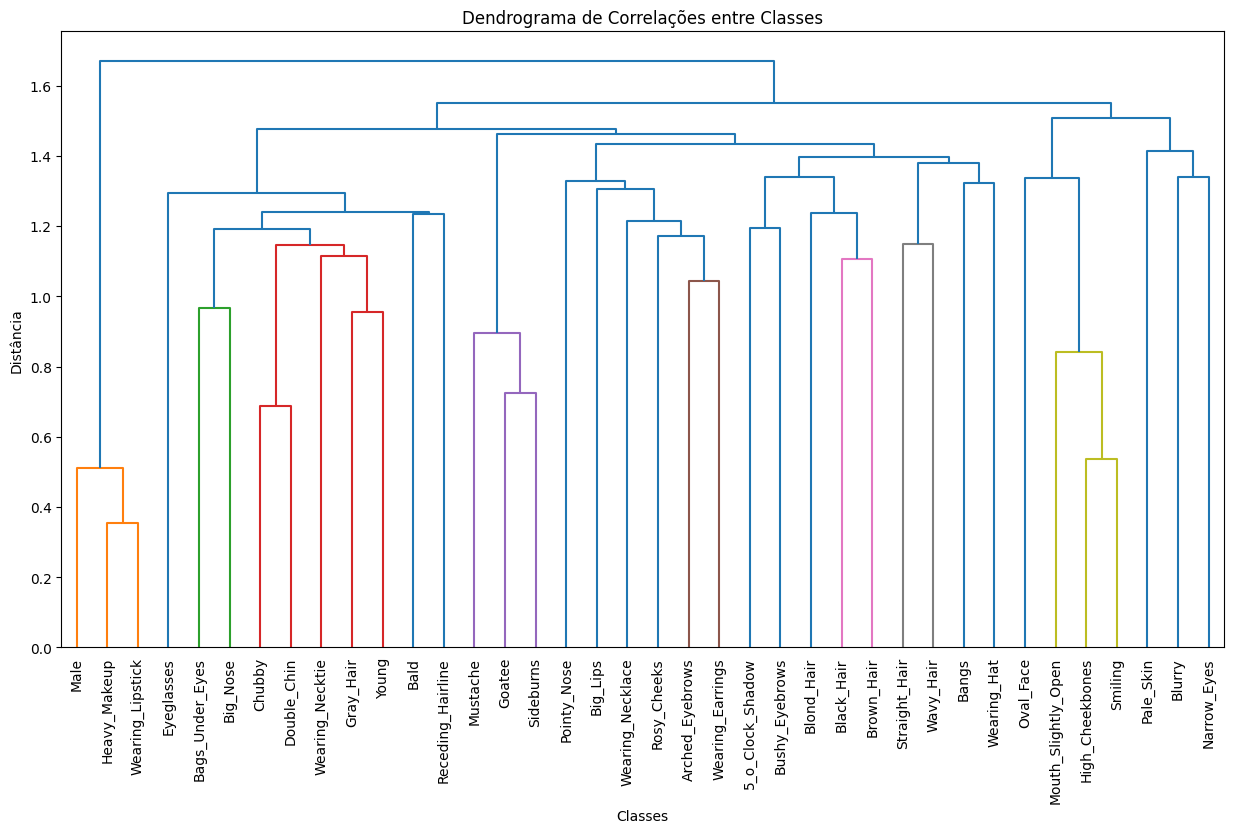

In [20]:
corr_matrix = df.iloc[:, 1:].corr()
clustering = AgglomerativeClustering(
    n_clusters=10,
    metric='precomputed',
    linkage='average'
)
distance_matrix = pdist(1 - abs(corr_matrix.values), metric='euclidean')
Z = linkage(distance_matrix, method='average')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma de Correlações entre Classes")
plt.xlabel("Classes")
plt.ylabel("Distância")
plt.show()


Certamente, ainda existem ajustes a serem feitos, mas esse processo é iterativo e incremental. E as mudanças mais óbvias foram realizadas.

__Vamos ver a nova distribuição das 38 classes restantes__

- Observe que agora a classe mais representada é `Young`.

Classe menos representada: Bald = 4547
Classe mais representada: Young = 156734


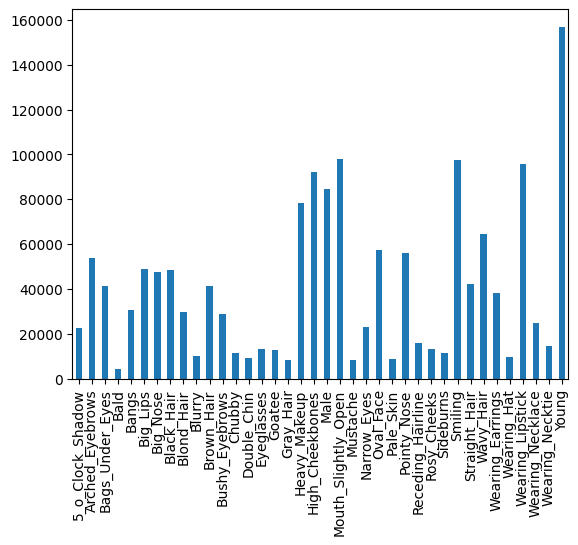

In [21]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

## Selecting the data

__Encontrando uma combinação de amostras equilibrada__

- A base é muito grande, e serão utilizadas no primeiro treino no máximo 3.500 imagens, 100 por classe, e sem data augmentation a princípio.

- O objetivo aqui é escolher aleatoriamente conjuntos de imagens que resulte em uma distribuição de classes mais equilibrada.

In [36]:
X = df.loc[:, 'image_id'].values.reshape(-1, 1)
y = df.iloc[:, 1:].values

In [58]:
import numpy as np
import random
import matplotlib.pyplot as plt

def find_balanced_subset(X, y, num_iterations=100, per_class=100, patience=100, seed=42):
    """
    Encontra um subconjunto balanceado de X e y que minimiza o desvio padrão relativo.

    :param X: Lista de nomes de arquivos (n_samples).
    :param y: Matriz binária indicando presença de classes (n_samples x num_classes).
    :param num_iterations: Número de iterações para encontrar o melhor conjunto.
    :param per_class: Número de amostras desejadas por classe no subconjunto.
    :param patience: Número máximo de iterações sem melhora para interromper o processo.
    :param seed: Semente para reprodutibilidade.
    :return: Subconjunto X_best, y_best com o menor desvio padrão relativo.
    """
    np.random.seed(seed)
    random.seed(seed)

    def calculate_std_relative(y):
        """
        Calcula o desvio padrão relativo das somas das classes em y.
        """
        return np.std(np.sum(y, axis=0)) / np.mean(np.sum(y, axis=0))

    def calculate_probabilities(y):
        """
        Calcula as probabilidades para amostragem com base na frequência de classes.
        """
        class_counts = np.sum(y, axis=0)
        class_weights = 1 / (class_counts + 1e-6)  # Inverso da frequência
        sample_weights = np.dot(y, class_weights)
        return sample_weights / np.sum(sample_weights)

    # Inicialização
    best_y_std_mean = calculate_std_relative(y)
    X_best, y_best = X, y
    p = calculate_probabilities(y_best)

    print('std mean inicial:', best_y_std_mean)

    no_improvement_count = 0

    for i in range(num_iterations):
        num_samples, num_classes = y_best.shape

        # Seleção de índices com probabilidades ajustadas
        selected_indices = np.random.choice(
            range(num_samples), size=per_class * num_classes, replace=False, p=p
        )
        selected_indices = np.sort(np.unique(selected_indices))

        # Subconjuntos selecionados
        y_sub = y[selected_indices]
        X_sub = [X[i] for i in selected_indices]

        # Calcula o desvio padrão relativo do subconjunto
        y_sub_std_mean = calculate_std_relative(y_sub)

        # Atualiza o melhor conjunto se o desvio for menor
        if y_sub_std_mean < best_y_std_mean:
            best_y_std_mean = y_sub_std_mean
            X_best, y_best = X_sub, y_sub
            p = calculate_probabilities(y_best)  # Atualiza probabilidades
            print(f"Iteração {i}: Melhor desvio padrão relativo = {best_y_std_mean:.4f}")
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Critério de parada antecipada
        if no_improvement_count >= patience:
            print("Parada antecipada: Sem melhora após", patience, "iterações.")
            break

    return X_best, y_best, best_y_std_mean


In [59]:
X_best, y_best, best_std_relative = find_balanced_subset(X, y, per_class=100, patience=500, num_iterations=50000)

print(f"Melhor conjunto encontrado com desvio padrão relativo: {best_std_relative:.4f}")
print(f"Tamanho do novo conjunto: {len(X_best)} imagens")


std mean inicial: 0.8324806448719143
Iteração 0: Melhor desvio padrão relativo = 0.6925
Parada antecipada: Sem melhora após 500 iterações.
Melhor conjunto encontrado com desvio padrão relativo: 0.6925
Tamanho do novo conjunto: 3800 imagens


In [60]:
y_best.shape

(3800, 38)

In [61]:
df_2 = df.loc[
    df.image_id.isin(np.array(X_best).reshape(-1)), :
]
df_2.to_csv(os.path.join(base_dir, 'datasets/celeb_a/attr_celeb_a_sample.csv'), index=False)

Classe menos representada: Bald = 4547
Classe mais representada: Young = 156734


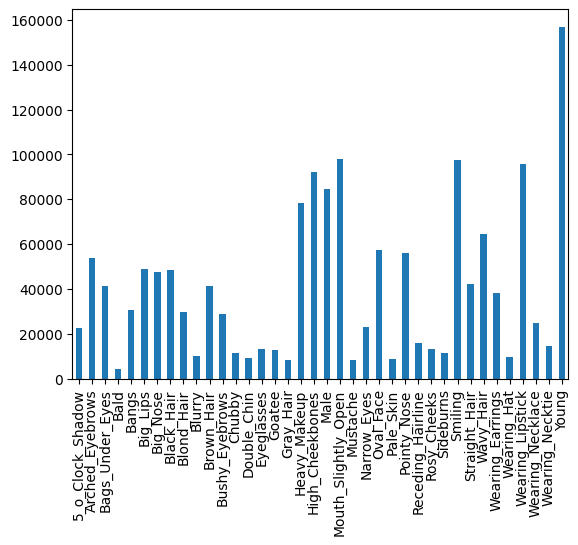

In [71]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

Classe menos representada: Bald = 234
Classe mais representada: Young = 2681


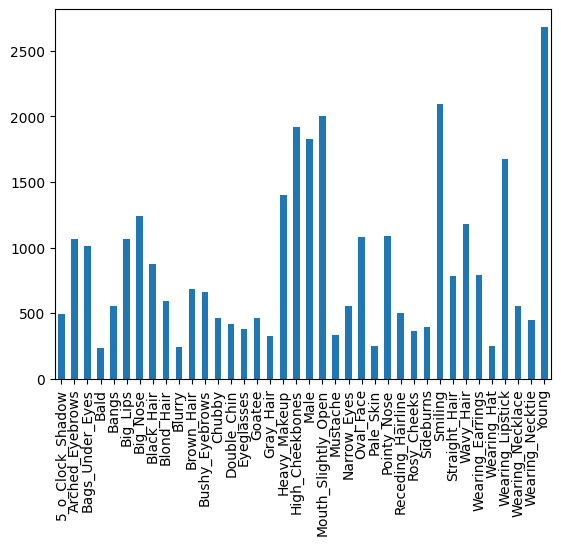

In [65]:
print(f'Classe menos representada: {df_2.columns[1:][df_2.iloc[:, 1:].sum().argmin()]} = {df_2.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df_2.columns[1:][df_2.iloc[:, 1:].sum().argmax()]} = {df_2.iloc[:, 1:].sum().max()}')
df_2.iloc[:, 1:].sum().plot(kind='bar');

## Conclusão

1. A partir dessa análise inicial já é esperado que o modelo terá dificuldade em diferenciar faces jovens de não jovens. É esperado que mulheres sejam classificadas como jovem mais frequentemente do que deveria, pois a principal variável associada à idade é o cabelo grisalho, que é mais frequente em homens.

2. Também, outras características relacionadas à idade estão mais atreladas aos homens, como bolsas abaixo dos olhos, papada, e um rosto com aparência mais rechonchuda. Estas são características que mulheres também podem apresentar, então há boa chance de mulheres com essas características serem classificadas como homens.

3. Na configuração anterior, o modelo também poderia ter dificuldade em associar pelos faciais com o gênero, devido a No_Beard.

4. Por fim, a primeira versão do modelo deve ser treinada, e a partir da inspeção das métricas podemos avaliar qual ponto de melhoria mais significante. De qualquer forma, com essa análise sabemos o que esperar do modelo.

__Próximo passo__: treino da rede com as 3.800 imagens selecionadas e 38 variáveis.